# Using multiple threads to parallelise linear algebra operations

*Parallelising workflows and code can be hard.  However, there are easy wins to be found in using Python code to interact with mature, multi-threaded compiled software libraries that can make good use of the multiple CPU cores in modern machines.*

## Learning outcomes

* Can parallelise linear algebra and fast Fourier transform operations using python packages and multithreaded compiled software libraries. 
* Can control the degree of parallelisation. 
* Able to explain some of the issues that might impact on how the runtimes of multi-threaded functions scale with the number of available CPU cores
* Can explain why hyperthreading is problematic for parallel numerical computations.

## Setup if using JupyterHub on ShARC

Pre-requisites if you want to run through this tutorial using the [JupyterHub service on the University of Sheffield's ShARC cluster][sharc-jh]. 

1.  [Connect][sharc-jh-conn-res-req-start] to JupyterHub on ShARC
1.  Request computational resources (CPUs, RAM etc) for a [new Jupyter session  on ShARC][sharc-jh-conn-res-req-start].  
    * **Project**: leave as the default unless you are participating in a workshop and your instructor tells you differently.
    * **Job Queue**: leave as `any` unless you are participating in a workshop and your instructor tells you differently.
    * **CPU cores**: `4`
    * **Parallel Environment**: `smp` (you want all requested CPU cores to be allocated on one node)
    * **RAM per CPU core**: `4` (GB)
    * **GPUS per CPU core**: 0
    * **Notebook session runtime**: currently fixed at four hours. 
1.  [Start][sharc-jh-conn-res-req-start] your Jupyter session
1. Ensure these tutorial Notebooks exist in your `/home` (`~`) (or `/data`) directory on ShARC (if that's not the case already).  Open a [Jupyter Terminal][sharc-jh-term] and run:

    ```sh
    cd ~  
    git clone git://github.com/RSE-Sheffield/hi-perf-ipynb/
    ```
    
    Leave this Jupyter Terminal open.
1.  For this tutorial we want to create a [conda environment][sharc-jh-conda] containing the packages we are going to use in this tutorial.
    1.  (From your Jupyter Terminal) tell Conda to download and install packages from a new package repository 
        in addition to the default package repository:

        ```sh
        conda config --append channels conda-forge
        ```
    
    1.  Create a new conda environment containing the software packages (and package versions) listed in 
        the `*-env.yml` file for this tutorial:

        ```sh
        cd ~/hi-perf-ipynb/tutorials 
        conda env create -n hi-perf-ipynb-multithreading -f 01-multithreading-env.yml
        ```
        
        NB you can open `01-multithreading-env.yml` via the [Jupyter File Browser][sharc-jh-file-browse] to
        see which packages we want installing.  
        The key ones are: `python jupyter pyfftw mkl-service matplotlib scipy numpy py-cpuinfo`

    
1. Open the [Jupyter File Browser][sharc-jh-file-browse] and browse to the `hi-perf-ipynb/tutorials` subdirectory within your home directory.  Click the `01-multithreading.ipynb` Notebook to open it.

1. Make sure your notebook is run in the correct conda environment:
    * Click *Kernel* -> *Change Kernel*
    * Select `Python [conda env:hi-perf-ipynb-multithreading]`

[sharc-jh-conn-res-req-start]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/conn_res_req_start.html
[sharc-jh]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub.html#using-jupyter-on-sharc
[sharc-jh-term]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/terminal.html
[sharc-jh-file-browse]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/file_browse.html
[sharc-jh-conda]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/conda.html

## Introduction

Linear algebra is a cornerstone of not just engineering and machine learning but many fields in academia and insdustry. Linear algebra operations are so important in computing that decades of research has gone into:

1. Finding the most efficient algorithms for solving them;
2. Developing the most efficient software implementations of those algorithms (usually written in [C][c] or [Fortran][fortran]);
3. Adding features to processors to help accelerate these operations (*more on this [later in this Notebook](#Using-the-MKL-on-CPUs-that-can-accelerate-certain operations)*)

For this reason **you need a *very* good reason to write your own linear algebra functions**.

The standard way to do linear algebra in software is to use one of the several heavily optimised [software libraries][soft-lib] that implement
the following specifications:

* [BLAS][blas] (*Basic Linear Algebra Subprograms*) - fundamental linear algebra functions e.g. matrix multiplication;
* [LAPACK][lapack] (*Linear Algebra Package*) - higher-level linear algebra functions that use BLAS functions.

One of the most efficient BLAS/LAPACK implementations is provided by the Intel Math Kernel Library ([MKL][mkl]),
which includes linear algebra functions that can make use of both 

* **shared-memory parallelism** (where multiple strands of parallel execution can read and write shared data in memory)
* particular accelerating functionality built into certain Intel processors (see 3. above).

<!-- TODO: shared-mem parallelism: reference theory section? --> 

The 'native' way to use the MKL is to write C or Fortran code but
for Python programmers the simplest approach is to use a version of the [numpy][numpy] Python package that was built so
it uses the MKL behind the scenes for linear algebra functionality
(plus other functionality such as [fast Fourier transforms][fft]).

Whether or not `numpy` comes with MKL support largely depends on how it was installed:

* `numpy` installed using conda (e.g. with [Miniconda or Anaconda][mini-ana-conda]) has MKL support and installs the MKL as a dependency
  (NB you need to install `numpy` from the default conda channel or [Intel Python Distribution][intel-conda] conda channel);
* _numpy installed using pip doesn't_!

## Multithreaded matrix multiplication using the MKL

**Let's see if we can use numpy and the MKL to execute a matrix multiplication operation in parallel using more than one CPU core.**

First, let's import some modules that we'll use later on this tutorial.

[blas]: https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms
[c]: https://en.wikipedia.org/wiki/C_(programming_language)
[dot-prod]: https://en.wikipedia.org/wiki/Dot_product
[fortran]: https://en.wikipedia.org/wiki/Fortran
[intel-conda]: https://anaconda.org/intel
[lapack]: https://en.wikipedia.org/wiki/LAPACK
[lin-alg]: https://en.wikipedia.org/wiki/Linear_algebra
[matr-mult-par]: https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Parallel_and_distributed_algorithms
[matr-mult]: https://en.wikipedia.org/wiki/Matrix_multiplication
[mkl]: https://software.intel.com/en-us/mkl
[numpy]: http://www.numpy.org/
[soft-lib]: https://en.wikipedia.org/wiki/Library_(computing)
[svd]: https://en.wikipedia.org/wiki/Singular-value_decomposition
[sys-lin-eq]: https://en.wikipedia.org/wiki/System_of_linear_equations
[fft]: https://en.wikipedia.org/wiki/Fast_Fourier_transform
[conda]: https://conda.io/
[mini-ana-conda]: https://conda.io/docs/user-guide/install/download.html

In [1]:
# Packages bundled with Python itself
import os
import subprocess
import timeit

# Installed packages
import cpuinfo  # provided by py-cpuinfo conda package
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import mkl  # provided by mkl-service conda package
import numpy as np
import scipy.linalg
import pyfftw

# Enable nicer Matplotlib styling
plt.style.use('ggplot')

# Automatically show Matplotlib plots in Notebook 
%matplotlib inline

Next, although we are confident that the installed numpy package has MKL support (as we installed `numpy` using `conda`), let's double check:

In [2]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/data/cs1wf/.conda-sharc/hi-perf-ipynb-multithreading/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/data/cs1wf/.conda-sharc/hi-perf-ipynb-multithreading/include']
blas_opt_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/data/cs1wf/.conda-sharc/hi-perf-ipynb-multithreading/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/data/cs1wf/.conda-sharc/hi-perf-ipynb-multithreading/include']
lapack_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/data/cs1wf/.conda-sharc/hi-perf-ipynb-multithreading/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/data/cs1wf/.conda-sharc/hi-perf-ipynb-multithreading/includ

If `mkl_rt` or `mkl_core` are listed as libraries under `blas_opt_info` and `lapack_opt_info` then the MKL is used for BLAS and LAPACK functionality.
Alternatively, If you installed numpy using pip then other BLAS/LAPACK library/libraries may be listed instead (e.g. `openblas`).

---

Next, let's create two square matrices:

In [3]:
# NB a 5000x5000 element matrix of 64-bit double-precision floating point numbers requires ~190 MiB of RAM
shape = (5000, 5000)

# Set the pseudo-random number generator (PRNG) seed for reproducibility
np.random.seed(42)
x = np.random.random_sample(shape)
y = np.random.random_sample(shape)
x[:5, :5]

array([[ 0.37454012,  0.95071431,  0.73199394,  0.59865848,  0.15601864],
       [ 0.39363552,  0.47343566,  0.85454739,  0.34000439,  0.86964968],
       [ 0.37364082,  0.3329121 ,  0.17615391,  0.60726667,  0.47662416],
       [ 0.49967024,  0.74674677,  0.56266678,  0.08330258,  0.18558024],
       [ 0.72999831,  0.184512  ,  0.34663969,  0.66328064,  0.48208934]])

We can then multiply these matrices using the new `@` operator ([introduced in Python 3.5](https://docs.python.org/3/whatsnew/3.5.html#pep-465-a-dedicated-infix-operator-for-matrix-multiplication)):

In [4]:
x @ y

array([[ 1243.99611873,  1225.27754335,  1238.75329532, ...,
         1222.51011125,  1230.53335804,  1229.3580307 ],
       [ 1241.56212906,  1222.2739218 ,  1232.48835462, ...,
         1233.16929273,  1198.14012781,  1227.64973873],
       [ 1257.56053544,  1245.53886902,  1259.30151897, ...,
         1242.19544737,  1233.81743487,  1255.55998311],
       ..., 
       [ 1252.99587376,  1238.00950078,  1267.58999895, ...,
         1237.29399088,  1232.83344863,  1246.00679243],
       [ 1270.80771334,  1254.8291935 ,  1271.18809836, ...,
         1259.05659341,  1242.28948977,  1261.1416097 ],
       [ 1239.93809614,  1248.47913077,  1264.4225269 , ...,
         1250.71653289,  1231.19191675,  1253.79828347]])

In this example, the MKL intelligently and silently detects:

* how many CPU cores are available in the machine;
* how many threads (parallel strands of execution) it could *efficiently* use for executing operation(s) in parallel (where #threads <= #cores to ensure all threads can run at once); 
* whether the CPU(s) in the machine have features that optionally can be used to accelerate the operation(s). 

and then uses multiple threads and CPU cores to multiply the matrices.  
Note that we haven't needed to tell numpy/MKL *how* to execute the matrix multiplication.

Let's look at what happens to the runtime of the matrix multiplication if we explicitly restrict the number of threads the MKL can create/use to 1, 2, 3 then 4 threads:

In [5]:
def sq_matr_mult_timings(side_length, thread_cnts, plot_results=False, prng_seed=None):
    """Time the multiplication of two generated square matrices using a set number of threads and optionally plot results.
    
    Parameters
    ----------
    side_length : 
        size of either dimension of the two square 
    thread_cnts : array_like
        sequence of thread/core counts for which to capture timings
    plot_results : optional
        Whether to plot timing data (default: False)
    prng_seed : optional
        pseudo-random-number-generator seed (default: None)    
    
    Returns
    -------
    (timings,)
        a sequence of timings the same length as thread_cnts 
    """
    shape = (side_length, side_length)
    if prng_seed:
        np.random.seed(prng_seed)
    x = np.random.random_sample(shape)
    y = np.random.random_sample(shape)

    timings = []
    for i in thread_cnts:
        # Set the maximum number of threads that can be used by the MKL
        mkl.set_num_threads(i)
        print("Thread count: {}".format(i), end=" -> ")

        # Execute matrix multiplication repeatedly for at least 0.2s whilst timing
        # NB in order to generate a timeit Timer that can see the references to x and y 
        # defined in this func we must use a lambda function (https://stackoverflow.com/a/31572755)
        n_itrs, t = timeit.Timer(lambda: x @ y).autorange()
        print("{:.3f} ms per iteration on average ({} iterations took {:.3f} s)".format(
            t * 1000 / n_itrs, n_itrs, t))
        timings.append(t * 1000  / n_itrs)
    
    if plot_results:
        fig, ax = plt.subplots()
        ax.scatter(thread_cnts, timings)
        ax.set_xticks(thread_cnts)
        ax.set_xticklabels(thread_cnts)
        ax.set_xlabel('# cores')
        ax.set_ylabel('Runtime [ms]');
        ax.set_ylim(0, max(timings) * 1.1);
        
    return timings

Here we use the `timeit` function to 

1. Execute a Python statement multiple times (to account for variation in system load), 
1. Take the minimum of those timings, as that is the most accurate representation of the thing we are trying to time   
1. Plot those timings.  

Here are the results (which take ~2 mins to compute):

Thread count: 1 -> 6395.170 ms per iteration on average (10 iterations took 63.952 s)
Thread count: 2 -> 3395.864 ms per iteration on average (10 iterations took 33.959 s)
Thread count: 3 -> 2292.431 ms per iteration on average (10 iterations took 22.924 s)
Thread count: 4 -> 1748.057 ms per iteration on average (10 iterations took 17.481 s)


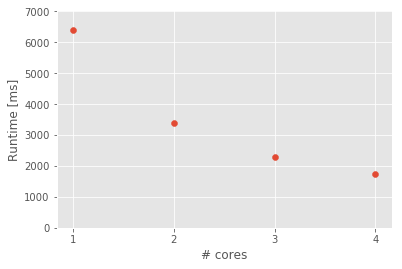

In [6]:
timings = sq_matr_mult_timings(5000, range(1, 5), plot_results=True)

As you can see, the runtime nearly decreases linearly with the requested maximum number of threads: we say we have almost achieved a **linear speedup**.  Here there are definitely benefits from using multiple threads and CPU cores!

Let's try that again but this time with a *much* smaller problem size.

Thread count: 1 -> 0.012 ms per iteration on average (100000 iterations took 1.217 s)
Thread count: 2 -> 0.011 ms per iteration on average (100000 iterations took 1.071 s)
Thread count: 3 -> 0.012 ms per iteration on average (100000 iterations took 1.153 s)
Thread count: 4 -> 0.013 ms per iteration on average (100000 iterations took 1.288 s)


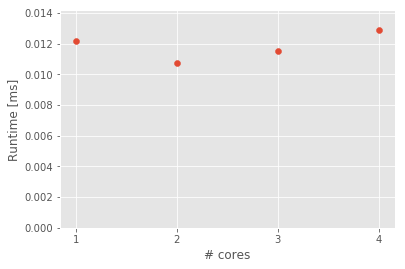

In [7]:
timings = sq_matr_mult_timings(50, range(1, 5), plot_results=True)

Here the scaling with CPU cores is non-existant.  Why?

---

You'd like to hope that as you distribute work between more threads that there will be a linear decrease in execution time.  However, that's not always the case:

  - If there are more threads than cores then threads will have to take it in turns to run;
  - For a given matrix size: as the number of threads grows, 
    at some point the cost of setup, tear-down and inter-thread communication/synchronisation may become significant. 
    **This is what is happening with the smaller problem size above**.
    As we _increase_ the problem size above that of the second example 
    then we should asymptotically converge on linear scaling.
  - It is useful to consider [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law) 
    when assessing how well a problem will scale with more parallelisation: 
    this law broadly states that speedup of parallelising some code is a limited by 
    the proportion that runs in series. 
    Assessing just how much code runs in series is difficult in this particular case as 
    
      - some code is visible in this Notebook, 
      - some is hidden in the numpy package and 
      - some is entirely hidden in the (propriatory) MKL. 
      
    In other situations it may be much easier for you to identify the sections of code that do (must?) 
    execute in series and therefore limit the maximum speedup achievable by parallelisation:
 
<img src="../static/parallel_code_with_serial_sections.svg" alt="Parallel code with serial sections" height="300px"
    width="200px" />

## If more cores and threads aren't always faster, how many cores do we need? 

This isn't an easy question to answer and depends on the problem size and on the algorithm and code used to solve the problem.  

On personal machines such as your own laptop it is therefore often best to just let the MKL decide on an appropriate number of threads.  This is what it does by default; we've only explicitly set the thread count here to demonstrate the effects of multithreading on performance.

On 'multi-tenant' systems such as HPC clusters like ShARC one typically needs to request the number of cores required at the start of the job then within the job there may be hundreds or possibly millions of multi-threadable linear algebra operations (or other multi-threadable operations if using something other than the MKL behind the scenes).   How many cores should one request of the Distributed Resource Manager that controls the cluster when you first submit/start your job?  Well, if you think you might benefit from multithreading and are using a library that supports it then try running some short *benchmark* tests with what you believe are the worst-case problem sizes within your job and, as above, capturing execution times for different thread/core counts to see how your problem scales with CPU cores.   

## Simple benchmarking outside Jupyter Notebooks

Here we created some benchmarking tests in Python using `timeit.autorange` and `mkl.set_num_threads`.  
However, if you're not using Python then you can: 

1.  Look to see what *profiling* / *timing* tools are available for your chosen programming environment.  
1.  Alternatively, on ShARC you could submit several [batch jobs][sharc-sge] that 
    [request different numbers of cores][sharc-sge] (using `-pe smp XX`) and 
    check how long each takes to run (by enabling [email notifications][sharc-sge]).

1.  Or, on your own machine or on ShARC you could use the `OMP_NUM_THREADS` environment variable 
    and the `time` command to control the number of MKL threads and time your application respectively.  

      * The `OMP_NUM_THREADS` environment variable is used by many software libraries/programs to 
        control how many threads can be created (and therefore the maximum number of CPU cores that will be used).  
      * `time` is just a program that you pass the name of a program (and its arguments, if it takes any) then
        it runs your program, monitors resource utilisation and reports back when your program exits.
        [A format string][time-fmt-str] can be used to control what informaiton it presents: 
        a useful string is `"%e %U %S"`, which tells `time` that you want to see
          * The real time (e.g. as measured by a wall clock, so often called *wall clock time*)
          * The 'user' time: the cumulative time all CPU cores spent running your program's instructions
          * The 'system' time: the cumulative time all CPU cores spent running 
            priviledged *kernel* (operating system) instructions on behalf of your program.
    
    Here's how you'd use `OMP_NUM_THREADS` and `time` to time a `OMP_NUM_THREADS`-aware program running 
    using up to two threads: 
      
    ```sh
    (OMP_NUM_THREADS=2 time -f "%e %U %S" ./my_program)
    ```

    And here's an example showing `OMP_NUM_THREADS` and `time` being used to benchmark a stand-along Python
    program that again multiplies two 5000x5000 matrices. You can run this **from a Jupyter (or other) terminal**.
    
    ---
    
    ```bash
    # Switch into the conda environment set up for the multithreading tutorial
    source activate hi-perf-ipynb-multithreading
    
    cd hi-perf-ipynb
    
    # Print the contents of our stand-alone Python program 
    # that multiplies two 5000x5000 numpy matrices
    cat matmultest.py

    echo "Real time, user time and system time for our program for different values of OMP_NUM_THREADS:"
    for nthreads in $(seq 1 4); do
        echo -n 1>&2 "Threads: $nthreads; timings:  "

        (OMP_NUM_THREADS=$nthreads time -f "%e %U %S" python matmultest.py)
    done
    ```
    
    ---
    
    Question: How does this approach differ for our matrix multiplication example?  Think about what operations we are timing here vs when we used `timeit` _within_ Python to time operations. 
    
[sharc-sge]: http://docs.hpc.shef.ac.uk/en/latest/hpc/scheduler/sge.html   
[time-fmt-str]: https://linux.die.net/man/1/time

## Tip: restricting the MKL to running on a subset of the available cores

When might we want to do this?  Well, one reason might be that we are wanting to execute multiple strands of our workflow and each involves linear algebra operations.  For optimal performance we might therefore want to run

* $n$ Python processes on $n$ cores, each of which 
* runs linear algebra functions using $1$ thread.

If each of the $n$ processes used $1<m<=n$ threads for the linear algebra functions then then there would be contention between the $n \cdot m$ threads for CPU time and we would not see any benefit to using multiple threads with the MKL. 

## A note on physical vs virtual processing cores (hyperthreading)

 Be aware that on the majority of modern Intel processors that each physical CPU core typically provides two *virtual cores* aka *hardware threads* using a technology called [Hyper-Threading](https://en.wikipedia.org/wiki/Hyper-threading). 
 
 
These virtual cores provide greater parallelism for workloads that are primarily IO (input/output) such as networking, running databases or interactive desktop/laptop usage.  However, you do not want to distribute floating-point calculations between both virtual cores of a physical core as the virtual cores share part of the physical core that handles floating-point calculations (the Floating Point Unit (FPU)).  Contention between virtual cores for the FPU can result in numerical workloads running slower with than if hyperthreading were disabled.  For this reason hyperthreading is disabled on all nodes in ShARC (bar a small number dedicated for CPU usage).  

You can check to see if hyperthreading is enabled using a program called `lstopo`, which shows the internal architecture of a machine.  Here's graphical output from `lstopo` for a Dell XPS 9550 laptop.  This shows that each of the four physical cores is comprised of two virtual cores i.e. hyperthreading is enabled. 
 
<img src="../static/dell-xps-9550-lstopo-cpu-ram.svg" alt="Parallel code with serial sections" width="30%"/>
 
Here's graphical output from running `lstopo` on ShARC within a 16-core job on a 16-core node where hyperthreading is disabled.  
 
<img src="../static/sharc-node005-lstopo-cpu-ram.svg" alt="Parallel code with serial sections" width="60%"/>

Run the following cell to see the architecture of the machine running this Jupyter Notebook.  *Note: if you run `lstopo` on the ShARC or Iceberg clusters you'll only see information on the CPU cores that have been allocated to your job*.  *Note: if you want to run `lstopo` on your own machine you need to install the [hwloc](https://www.open-mpi.org/projects/hwloc/) library.

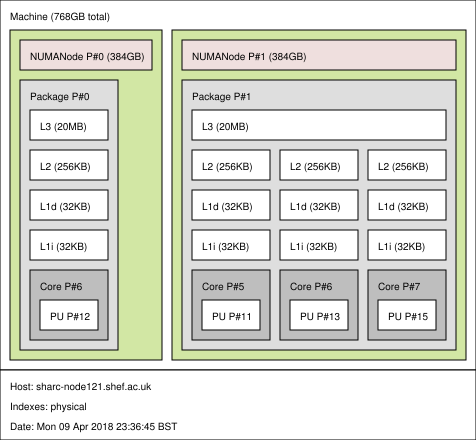

In [8]:
# Create an empty temporary file
tmp = os.path.join(os.sep, 
                   os.environ['TMPDIR'] if 'TMPDIR' in os.environ else 'tmp',
                   str(os.getpid()))

# Run the lstopo command-line utility to capture information about available hardware resources,
# generate a SVG image from that data and save the SVG to our temporary file
subprocess.check_output(['lstopo', '--no-io', 
                                   '--no-bridges', 
                                   '--output-format', 'svg', 
                                   '-f', tmp])

# Display the SVG in this Notebook
with open(tmp, 'r') as svg_file:
    svg = svg_file.read()
SVG(svg)

## So what else can use the MKL for multithreaded linear algebra?

A variety of Python packages distributed using conda can use the MKL for multithreaded linear algebra, either by depending on numpy to talk to the MKL or by using the MKL directly.  

The scipy package, for example, can use the MKL to accelerate more involved operations such as [singular value decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) (a means for factorising a real- or complex-valued matrix):

In [9]:
z = np.random.random_sample((1500, 500))

def svd_duration_ms(matr, n_threads):
    """Time a singular value decomposition (SVD)

    Parameters
    ----------
    matr : 
        numpy matrix to perform SVD on 
    n_threads : 
        number of threads to use with MKL    

    Returns
    -------
    timing - duration in milliseconds
    """
    print("Thread count: {}".format(n_threads), end=" -> ")
    mkl.set_num_threads(n_threads)

    n_itrs, t = timeit.Timer(lambda: scipy.linalg.svd(matr)).autorange()                                                                                                             
    print("{:.3f} ms per iteration on average ({} iterations took {:.3f} s)".format(                                                                                                 
          t * 1000 / n_itrs, n_itrs, t))                                                                                                                                           
    return t * 1000  / n_itrs                                                                                                                                                        

timings = [svd_duration_ms(z, n) for n in range(1, 5)]   

Thread count: 1 -> 299.139 ms per iteration on average (10 iterations took 2.991 s)
Thread count: 2 -> 182.612 ms per iteration on average (10 iterations took 1.826 s)
Thread count: 3 -> 151.791 ms per iteration on average (10 iterations took 1.518 s)
Thread count: 4 -> 133.928 ms per iteration on average (10 iterations took 1.339 s)


Here the speedup is not quite linear (NB thread counts <= the number of cores): there is value in using multiple cores with this size of problem.   

Above, we discussed how we don't benefit from having more threads than cores (at least for numerical problems).  Here we demonstrate that we get no further benefit from increasing the number of threads beyond the number of available CPU cores:     

In [10]:
timings = [svd_duration_ms(z, n) for n in range(5, 9)]

Thread count: 5 -> 196.018 ms per iteration on average (10 iterations took 1.960 s)
Thread count: 6 -> 764.213 ms per iteration on average (10 iterations took 7.642 s)
Thread count: 7 -> 1278.609 ms per iteration on average (10 iterations took 12.786 s)
Thread count: 8 -> 1057.563 ms per iteration on average (10 iterations took 10.576 s)


As you can see, in this case we actually get a performance regression when we go beyond the number of cores available in the machine:
  - CPU cores are each having to rapidly switch between (on average 2) threads so as to run them concurrently.
  - This **context switching** is expensive in terms of time as on-CPU memory registers and memory caches need to be updated on each context switch.
  - You may hear the term **oversubscription** used to describe running more threads than you have CPU cores.
       
Again, you're best letting the MKL decide on an appropriate thread count!

## A third example: accelerating FFTs using pyfftw and multiple threads

As we've seen, numpy can use the Intel MKL for multi-threaded linear algebra operations. 
The MKL also includes [fast Fourier transform][fft-wikipedia] (FFT) functions
that can also use multiple threads and therefore multiple cores for distributing work. 
However, although the numpy FFT functions can use the MKL for FFT calculations 
the MKL is not called in a way that allows multiple threads to be used efficiently 
(see [this blog post][numpy-mkl-fft-blog]).

Let's use this an opportunity to explore how a different Python package, [pyfftw][pyfftw], uses a different compiled library, [FFTW][fftw], to provide efficient multithreaded FFT functions.  FFTW is a very widely used and mature FFT library that can calculate 1D, 2D and 3D forward and inverse FFTs. 

*Note: don't worry if you haven't encountered (fast) Fourier transforms yet - that's not directly relevant here, the use of Python to drive multithreaded compiled libraries is. For interest, Fourier transforms convert signals from time vs magnitude to time vs frequency (and vice versa).*                                                                                        

Here we use pyfftw's native and most efficient way of calculating FFTs, which involves preallocating input and output arrays then generating then evaluating a execution plan.  If you want a more concise way of using pyfftw that presents an interface that very closely mirrors the FFT-related parts of the numpy API then see `pyfftw.interfaces.numpy_fft.fft` and/or `pyfftw.builders.fft`.

[fft-wikipedia]: (https://en.wikipedia.org/wiki/Fast_Fourier_transform)
[numpy-mkl-fft-blog]: http://rse.shef.ac.uk/blog/numpy-mkl-fft/
[pyfftw]: https://hgomersall.github.io/pyFFTW/
[fftw]: http://fftw.org

1600.967 ms per iteration on average (10 iterations took 16.010 s)
866.292 ms per iteration on average (10 iterations took 8.663 s)
692.502 ms per iteration on average (10 iterations took 6.925 s)
644.991 ms per iteration on average (10 iterations took 6.450 s)


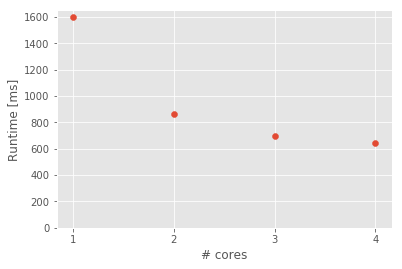

In [17]:
# Size of 3D FFT input
size = (1024, 1024, 256)

# Preallocate a 2GB array of complex values for storing randomly generated input data.
# This preallocation allows the array to be 'aligned' in memory in a way that offers 
# best performance on hardware with SIMD support (e.g. with AVX support; see mention of SIMD in the next section)
a = pyfftw.empty_aligned(size, dtype='complex128')
out = pyfftw.empty_aligned(size, dtype='complex128')

# Randomly generate the real and imaginary components of our 3D FFT input
a[:] = np.random.randn(*size) + (1j * np.random.randn(*size))

# To store timings for the FFT calculations
timings = []

# Range of thread counts for which to measure performance
thread_cnts = np.arange(1, 5)

for i in thread_cnts:
    # Constructs a plan for how to calculate the FFT efficiently given the input data type and size 
    # Note that we're not timing this setup function
    fft_plan = pyfftw.FFTW(a, out, threads=i) 
    
    # Time the FFT calculation
    n_itrs, t = timeit.Timer(lambda: fft_plan.execute()).autorange()                                                                                                             
    print("{:.3f} ms per iteration on average ({} iterations took {:.3f} s)".format(                                                                                                 
          t * 1000 / n_itrs, n_itrs, t))   
    timings.append(t * 1000  / n_itrs)
    
# Plot the results
fig, ax = plt.subplots()
ax.scatter(thread_cnts, timings)
ax.set_xticks(thread_cnts)
ax.set_xticklabels(thread_cnts)
ax.set_xlabel('# cores')
ax.set_ylabel('Runtime [ms]');
ax.set_ylim(ymin=0);

# Free memory
del a, out

Note that for *this* 3D array of complex values the forward FFT scaling doesn't improve much beyond a couple of cores.

## Tip: Using the MKL on CPUs that can accelerate certain operations 

Another easy win when it comes to performance is making sure that you use the MKL on CPU(s) that have:

  * Support for atomically applying the same operation to vectors of values 
    ('Single Instruction Multiple Data' **(SIMD) hardware vectorisation**) in hardware using 
    some flavour of Intel's [Advanced Vector Extensions][avx] (AVX). 
    For example, a processor that supports SIMD could compute the addition of two four-integer vectors using
    references to two 'vector units' in memory and a single operation:

    ```
    a0     b0
    a1  +  b1
    a2     b2
    a3     b3
    ```
    rather than four operations:

    ```
    a0 + b0
    a1 + b1
    a2 + b2
    a3 + b3
    ```

    (if suppilied with the correct CPU instructions).

  * Support for atomically multiplying two values and adding them to 
    an 'accumulator' CPU [register][cpu-reg] (storage location on the CPU). 
    This CPU instruction, known as [fused multiply-add][fma] (FMA), can help 
    speed up matrix multiplication as that operation consists entirely of sums of multiplications.  

**You can get additional performance out of many libraries, *not just the MKL*, if they are able to use AVX and/or FMA**.  

With AVX this typically requires that software is written and compiled so that it is AVX-aware but the MKL is able to just detect and use AVX and FMA at execution time, making life much easier for the numpy user.  

The CPUs in the ShARC cluster at the University of Sheffield have both AVX2 and FMA support. You can check if you have AVX and/or FMA support using the [cpuinfo][cpuinfo] Python package:

[avx]: https://en.wikipedia.org/wiki/Advanced_Vector_Extensions
[cpu-reg]: https://en.wikipedia.org/wiki/Processor_register
[fma]: https://en.wikipedia.org/wiki/Multiply%E2%80%93accumulate_operation#Fused_multiply%E2%80%93add
[cpuinfo]: https://github.com/workhorsy/py-cpuinfo

In [13]:
cpu_features = cpuinfo.get_cpu_info()['flags']
# See whether particular CPU features of interest are in the set of all available features
set(cpu_features).intersection(set(('fma', 'avx', 'avx2', 'avx512')))

{'avx', 'avx2', 'fma'}

or from the command-line:

In [14]:
!grep -oE '\W(fma|avx|avx2)\W' /proc/cpuinfo | sort | uniq

 avx 
 avx2 
 fma 


*Jupyter Tip: if a line in a code cell starts with `!` then the rest of the line is run in a shell, not executed as Python code.  Omit the '`"`' if you want to run the line from a Jupyter Terminal or ordinary terminal.*  

## Summary

We've taken a meandering tour through 
* Multithreading using `numpy` + the MKL and `pyfftw`;
* Looked at how to measure how well the problem scales with CPU cores (using both the `timeit` module and command-line based approaches to timing operations) and qualified what is meant by *linear scaling*;
* Talked about we may want to avoid oversubscription and the associated context switching if we are working on intensely numerical computation, and how the MKL can simplify matters for us by dynamically selecting an appropriate number of threads; 
* Discussed *hyperthreading* and how performance may not scale well to the total number of hyperthreads if our problem consists mostly of floating point operations as the hyperthreads of a physical core share a CPU *floating point unit*;
* Briefly discussed how we may want to *explicitly limit/control multithreading* if we have higher-level parallelism in our workflow.
* briefly discussed *SIMD (hardware) vectorisation* and *fused multiply-add* operations and how to check if hardware support for these is available.